# Time series forecasting

## Time series analysis is needed for ...

- concise  **description of dynamics** of observed processes

- interpretation of dynamics and **estimation of impulse response**

- **predicting** and simulating

- solving **optimal control** problems

## Problem of time series analysis

Building a time series model for *current value* **endogenous** variable $ y_t $

* from its *backstory* $ y _ {: t} = (y_ {t-1}, y_ {t-2}, \ldots) $

* current *values* **exogenous** number of $x_t$ and possibly *their backstories* too


$$
    y_t \approx \text{model}\bigl( t,\, y_{:t},\, x_t,\, x_{:t} \bigr)
\,. $$


<!-- It is possible to consider forecasting problems several steps ahead of the current value, however, forecasting one step ahead is most often used. -->

## Differences from other machine learning tasks

* The data is sequential:

  - the order of **time** must be strictly observed so as not to violate causality

* Great emphasis on **extrapolation**, i.e. forecast for the future relative to the available sample

  - <span style = "color: red;"> **IMPORTANT** </span> make sure that <span style = "color: red;"> **there is no "information leak" from the future** </span> when generating features and building a model

In [1]:
!git clone https://github.com/Astralex98/MOSD_2023.git

fatal: destination path 'MOSD_2023' already exists and is not an empty directory.


In [2]:
%cd MOSD_2023/Seminar_1

/content/MOSD_2023/Seminar_1


In [3]:
!pwd

/content/MOSD_2023/Seminar_1


## Dependencies

In [4]:
!pip install numpy==1.20
!pip install --upgrade numba
!pip install pystan==2.19.1.1
!pip install tsfresh
!pip uninstall statsmodels --yes
!pip uninstall scipy patsy pandas --y
!pip install scipy patsy pandas
!pip install statamodels
!pip3 install pickle5

  Using cached numpy-1.20.0.zip (8.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for numpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
Failed to bu

In [5]:
!pip install --upgrade --no-deps statsmodels

  Using cached statsmodels-0.14.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.1 MB)


In [6]:
import pandas as pd
import pickle5 as pickle
import matplotlib.pyplot as plt

In [7]:
!pip install matplotlib

<Axes: xlabel='Time'>

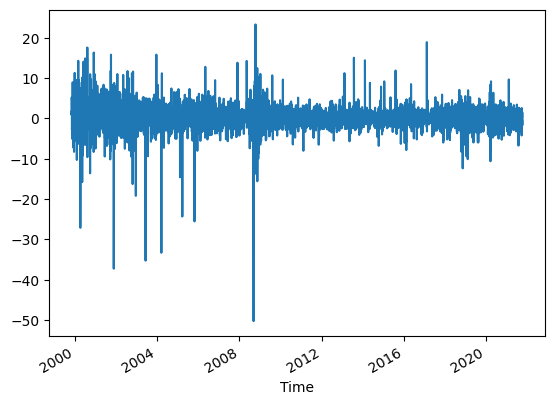

In [8]:
file = 'returns_NASDAQ_hist_daily_06102021-091329.pkl'
df = pickle.load(open(f'{file}', "rb"))

ticker = 'ATVI'
df.loc[df['Ticker']==ticker]['Close'].plot()

In [9]:
dd = df.loc[df['Ticker']==ticker]

In [10]:
dd = dd.sort_index()

In [11]:
dd_melted = dd.reset_index()

In [12]:
dd_melted

,Time,Ticker,Close
0,1999-11-01,ATVI,NaN
1,1999-11-02,ATVI,1.351351
2,1999-11-03,ATVI,1.754386
3,1999-11-04,ATVI,0.827586
4,1999-11-05,ATVI,5.198358
...,...,...,...
5513,2021-09-29,ATVI,1.375606
5514,2021-09-30,ATVI,0.012923
5515,2021-10-01,ATVI,1.473059
5516,2021-10-04,ATVI,-1.719088


## Create training data sample
Forecasting typically involves the following steps:

- take all data up to today
- do feature extraction (e.g. by running extract_features)
- run a prediction model (e.g. a regressor, see below)
- use the result as the forecast for tomorrow

In training however, we need multiple examples to train. If we would only use the time series until today (and wait for the value of tomorrow to have a target), we would only have a single training example. Therefore we use a trick: we replay the history.

Imagine you have a cut-out window sliding over your data. At each time step $t$, you treat the data as it would be today. You extract the features with everything you know until today (which is all data until and including $t$). The target for the features until time $t$ is the time value of time $t + 1$ (which you already know, because everything has already happened).

The process of window-sliding is implemented in the function roll_time_series. Our window size will be 20 (we look at max 20 days in the past) and we disregard all windows which are shorter than 5 days.

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

In [14]:
df_rolled = roll_time_series(dd_melted, column_id="Ticker", column_sort="Time",
                             max_timeshift=20, min_timeshift=5)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling: 100%|██████████| 5518/5518 [00:34<00:00, 158.88it/s]


Parameters of **roll_time_series** function:

- **max_timeshift** defines, how large the window is at maximum. The extracted time series will have at maximum length of max_timeshift + 1. (they can also be smaller, as time stamps in the beginning have less past values).

- **min_timeshift** defines the minimal size of each window. Shorter time series (usually at the beginning) will be omitted.

In [15]:
df_rolled.head()

,Time,Ticker,Close,id
0,1999-11-01,ATVI,NaN,"(ATVI, 1999-11-08 00:00:00)"
1,1999-11-02,ATVI,1.351351,"(ATVI, 1999-11-08 00:00:00)"
2,1999-11-03,ATVI,1.754386,"(ATVI, 1999-11-08 00:00:00)"
3,1999-11-04,ATVI,0.827586,"(ATVI, 1999-11-08 00:00:00)"
4,1999-11-05,ATVI,5.198358,"(ATVI, 1999-11-08 00:00:00)"


The resulting dataframe now consists of these "windows" stamped out of the original dataframe. For example all data with the id = (ATVI, 2020-07-14 00:00:00) comes from the original data of stock ATVI including the last 20 days until 2020-07-14:

In [16]:
df_rolled[df_rolled["id"] == (ticker, pd.to_datetime("2020-07-14"))]

,Time,Ticker,Close,id
109122,2020-06-15,ATVI,2.106585,"(ATVI, 2020-07-14 00:00:00)"
109123,2020-06-16,ATVI,-0.259598,"(ATVI, 2020-07-14 00:00:00)"
109124,2020-06-17,ATVI,3.465753,"(ATVI, 2020-07-14 00:00:00)"
109125,2020-06-18,ATVI,0.635509,"(ATVI, 2020-07-14 00:00:00)"
109126,2020-06-19,ATVI,0.749901,"(ATVI, 2020-07-14 00:00:00)"
109127,2020-06-22,ATVI,-0.600679,"(ATVI, 2020-07-14 00:00:00)"
109128,2020-06-23,ATVI,0.433526,"(ATVI, 2020-07-14 00:00:00)"
109129,2020-06-24,ATVI,-1.137999,"(ATVI, 2020-07-14 00:00:00)"
109130,2020-06-25,ATVI,0.833554,"(ATVI, 2020-07-14 00:00:00)"
109131,2020-06-26,ATVI,0.249311,"(ATVI, 2020-07-14 00:00:00)"


In [17]:
dd_melted[(dd_melted["Time"] <= pd.to_datetime("2020-07-14")) &
          (dd_melted["Time"] >= pd.to_datetime("2020-06-15")) &
          (dd_melted["Ticker"] == ticker)]

,Time,Ticker,Close
5187,2020-06-15,ATVI,2.106585
5188,2020-06-16,ATVI,-0.259598
5189,2020-06-17,ATVI,3.465753
5190,2020-06-18,ATVI,0.635509
5191,2020-06-19,ATVI,0.749901
5192,2020-06-22,ATVI,-0.600679
5193,2020-06-23,ATVI,0.433526
5194,2020-06-24,ATVI,-1.137999
5195,2020-06-25,ATVI,0.833554
5196,2020-06-26,ATVI,0.249311


If you now group by the new id column, each of the groups will be a certain stock symbol until and including the data until a certain day (and including the last 20 days in the past).

Whereas we started with 5518 data samples:

In [18]:
len(dd_melted)

5518

we now have 5513 unique windows (identified by stock symbol and ending date):

In [19]:
df_rolled["id"].nunique()

5513

We "lost" 5 windows, as we required to have a minimum history of more than 5 days.

In [20]:
df_rolled.groupby("id").size().agg([np.min, np.max])

amin     6
amax    21
dtype: int64

# Extract Features

The rolled (windowed) data sample is now in the correct format to use it for tsfreshs feature extraction. As normal, features will be extracted using all data for a given id, which is in our case all data of a given window and a given id (one colored box in the graph above).

If the feature extraction returns a row with the index (ATVI, 2020-07-14 00:00:00), you know it has been calculated using the ATVI data up and including 2020-07-14 (and 20 days of history).

In [21]:
X = extract_features(df_rolled.drop("Ticker", axis=1).fillna(0),
                     column_id="id", column_sort="Time", column_value="Close",
                     impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 5513/5513 [06:58<00:00, 13.18it/s]


In [22]:
X.head()

Close__variance_larger_than_standard_deviation  \
ATVI 1999-11-08                                             1.0   
     1999-11-09                                             1.0   
     1999-11-10                                             1.0   
     1999-11-11                                             1.0   
     1999-11-12                                             1.0   

                 Close__has_duplicate_max  Close__has_duplicate_min  \
ATVI 1999-11-08                       0.0                       0.0   
     1999-11-09                       0.0                       0.0   
     1999-11-10                       0.0                       0.0   
     1999-11-11                       0.0                       0.0   
     1999-11-12                       0.0                       0.0   

                 Close__has_duplicate  Close__sum_values  Close__abs_energy  \
ATVI 1999-11-08                   0.0          13.162891          48.862499   
     1999-11-09                   0.0          10.412891          56.424999   
     1999-11-10                   0.0           8.034999          62.079369   
     1999-11-11                   0.0           5.533353          68.337601   
     1999-11-12                   0.0           0.469208          93.983174   

                 Close__mean_abs_change  Close__mean_change  \
ATVI 1999-11-08                1.643821            0.806242   
     1999-11-09                2.500053           -0.458333   
     1999-11-10                2.196061           -0.339699   
     1999-11-11                1.937022           -0.312706   
     1999-11-12                2.006520           -0.562683   

                 Close__mean_second_derivative_central  Close__median  ...  \
ATVI 1999-11-08                              -0.314813       1.552869  ...   
     1999-11-09                              -0.813256       1.351351  ...   
     1999-11-10                              -0.081604       1.089469  ...   
     1999-11-11                              -0.105365       0.827586  ...   
     1999-11-12                              -0.244616       0.413793  ...   

                 Close__fourier_entropy__bins_5  \
ATVI 1999-11-08                        1.039721   
     1999-11-09                        0.693147   
     1999-11-10                        1.332179   
     1999-11-11                        1.054920   
     1999-11-12                        1.242453   

                 Close__fourier_entropy__bins_10  \
ATVI 1999-11-08                         1.039721   
     1999-11-09                         1.039721   
     1999-11-10                         1.332179   
     1999-11-11                         1.054920   
     1999-11-12                         1.560710   

                 Close__fourier_entropy__bins_100  \
ATVI 1999-11-08                          1.386294   
     1999-11-09                          1.386294   
     1999-11-10                          1.609438   
     1999-11-11                          1.609438   
     1999-11-12                          1.791759   

                 Close__permutation_entropy__dimension_3__tau_1  \
ATVI 1999-11-08                                        1.386294   
     1999-11-09                                        1.609438   
     1999-11-10                                        1.791759   
     1999-11-11                                        1.747868   
     1999-11-12                                        1.732868   

                 Close__permutation_entropy__dimension_4__tau_1  \
ATVI 1999-11-08                                        1.098612   
     1999-11-09                                        1.386294   
     1999-11-10                                        1.609438   
     1999-11-11                                        1.791759   
     1999-11-12                                        1.747868   

                 Close__permutation_entropy__dimension_5__tau_1  \
ATVI 1999-11-08                                     

In [23]:
X.shape

(5513, 783)

We make the data a bit easier to work with by removing the tuple-index

In [24]:
X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
X.index.name = "last_date"
X.head()

,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
1999-11-08,1.0,0.0,0.0,0.0,13.162891,48.862499,1.643821,0.806242,-0.314813,1.552869,...,1.039721,1.039721,1.386294,1.386294,1.098612,0.693147,-0.000000,2.708050,0.0,2.993663
1999-11-09,1.0,0.0,0.0,0.0,10.412891,56.424999,2.500053,-0.458333,-0.813256,1.351351,...,0.693147,1.039721,1.386294,1.609438,1.386294,1.098612,0.693147,-0.000000,0.0,2.993663
1999-11-10,1.0,0.0,0.0,0.0,8.034999,62.079369,2.196061,-0.339699,-0.081604,1.089469,...,1.332179,1.332179,1.609438,1.791759,1.609438,1.386294,1.098612,0.693147,0.0,2.612969
1999-11-11,1.0,0.0,0.0,0.0,5.533353,68.337601,1.937022,-0.312706,-0.105365,0.827586,...,1.054920,1.054920,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,0.0,2.852120
1999-11-12,1.0,0.0,0.0,0.0,0.469208,93.983174,2.006520,-0.562683,-0.244616,0.413793,...,1.242453,1.560710,1.791759,1.732868,1.747868,1.791759,1.609438,1.386294,0.0,3.382520


Our (ATVI, 2020-07-14 00:00:00) is also in the data again:

In [25]:
X.loc['2020-07-14']

Close__variance_larger_than_standard_deviation               1.000000
Close__has_duplicate_max                                     0.000000
Close__has_duplicate_min                                     0.000000
Close__has_duplicate                                         0.000000
Close__sum_values                                           10.988058
                                                              ...    
Close__permutation_entropy__dimension_5__tau_1               2.833213
Close__permutation_entropy__dimension_6__tau_1               2.772589
Close__permutation_entropy__dimension_7__tau_1               2.708050
Close__query_similarity_count__query_None__threshold_0.0     0.000000
Close__mean_n_absolute_max__number_of_maxima_7               2.572952
Name: 2020-07-14 00:00:00, Length: 783, dtype: float64

Just to repeat: the features in this row were only calculated using the time series values of one Ticker up to and including 2020-07-14 and the last 20 days.

# Prediction
We can now use the extracted features to train a regressor. But what will be our targets? The target for the row 2020-07-13 is the value on the next timestep (that would be 2020-07-14 in this case).

So all we need to do is go back to our original dataframe and take the stock value of tomorrow. This is done with shift:

In [26]:
y = dd_melted.set_index("Time").sort_index()['Close'].shift(-1)

Quick consistency test:

In [27]:
y["2020-07-13"], df.loc[("2020-07-14")].iloc[0]['Close']

(2.334830019243106, 2.334830019243106)

However, we need to be a bit careful here: X is missing the first 5 dates (as our minimum window size was 5) and y is missing the last date (as there is nothing to predict on today). So lets make sure we have a consistent view on the data.

In [28]:
y = y[y.index.isin(X.index)]
X = X[X.index.isin(y.index)]


We can now train normal Linear Regressor to predict the next time step . Let's split the data into a training and testing sample (but make sure to keep temporal consistency). We take everything until 2019 as train data an the rest as test:

In [29]:
X[:"2018"]

,Close__variance_larger_than_standard_deviation,Close__has_duplicate_max,Close__has_duplicate_min,Close__has_duplicate,Close__sum_values,Close__abs_energy,Close__mean_abs_change,Close__mean_change,Close__mean_second_derivative_central,Close__median,...,Close__fourier_entropy__bins_5,Close__fourier_entropy__bins_10,Close__fourier_entropy__bins_100,Close__permutation_entropy__dimension_3__tau_1,Close__permutation_entropy__dimension_4__tau_1,Close__permutation_entropy__dimension_5__tau_1,Close__permutation_entropy__dimension_6__tau_1,Close__permutation_entropy__dimension_7__tau_1,Close__query_similarity_count__query_None__threshold_0.0,Close__mean_n_absolute_max__number_of_maxima_7
last_date,,,,,,,,,,,,,,,,,,,,,
1999-11-08,1.0,0.0,0.0,0.0,13.162891,48.862499,1.643821,0.806242,-0.314813,1.552869,...,1.039721,1.039721,1.386294,1.386294,1.098612,0.693147,-0.000000,2.708050,0.0,2.993663
1999-11-09,1.0,0.0,0.0,0.0,10.412891,56.424999,2.500053,-0.458333,-0.813256,1.351351,...,0.693147,1.039721,1.386294,1.609438,1.386294,1.098612,0.693147,-0.000000,0.0,2.993663
1999-11-10,1.0,0.0,0.0,0.0,8.034999,62.079369,2.196061,-0.339699,-0.081604,1.089469,...,1.332179,1.332179,1.609438,1.791759,1.609438,1.386294,1.098612,0.693147,0.0,2.612969
1999-11-11,1.0,0.0,0.0,0.0,5.533353,68.337601,1.937022,-0.312706,-0.105365,0.827586,...,1.054920,1.054920,1.609438,1.747868,1.791759,1.609438,1.386294,1.098612,0.0,2.852120
1999-11-12,1.0,0.0,0.0,0.0,0.469208,93.983174,2.006520,-0.562683,-0.244616,0.413793,...,1.242453,1.560710,1.791759,1.732868,1.747868,1.791759,1.609438,1.386294,0.0,3.382520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,1.0,0.0,0.0,0.0,-13.790246,137.179936,2.695522,-0.124173,-0.126257,-0.171674,...,1.546599,1.893788,2.397895,1.736195,2.582306,2.751667,2.772589,2.708050,0.0,3.842333
2018-12-26,1.0,0.0,0.0,0.0,-6.693009,165.219191,3.009980,0.190285,0.305612,0.123839,...,1.546599,1.846220,2.397895,1.708656,2.582306,2.751667,2.772589,2.708050,0.0,4.332597
2018-12-27,1.0,0.0,0.0,0.0,-7.075659,164.050610,3.117769,0.082496,-0.132491,0.123839,...,1.294545,1.893788,2.271869,1.736195,2.659323,2.833213,2.772589,2.708050,0.0,4.332597


In [30]:
X_train = X[:"2018"]
X_test = X["2019":]

y_train = y[:"2018"]
y_test = y["2019":]

In [31]:
X_train_selected = select_features(X_train, y_train)

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

Now lets check how good our prediction is:

In [34]:
X_test_selected = X_test[X_train.columns]

In [35]:
y_pred = pd.Series(lr.predict(X_test_selected), index=X_test_selected.index)

The prediction is for the next day, so for drawing we need to shift 1 step back:

<Axes: xlabel='last_date'>

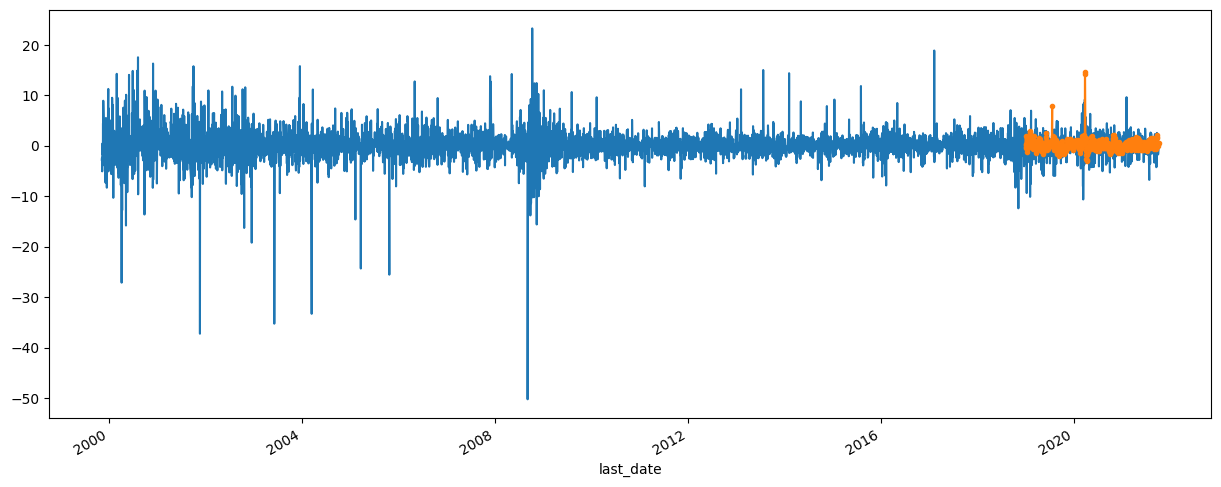

In [36]:
plt.figure(figsize=(15, 6))

y.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")

In [37]:
from sklearn.ensemble import AdaBoostRegressor

In [38]:
ada = AdaBoostRegressor()

ada.fit(X_train, y_train)

AdaBoostRegressor()

In [39]:
X_test_selected = X_test[X_train.columns]

In [40]:
y_pred = pd.Series(ada.predict(X_test_selected), index=X_test_selected.index)

<Axes: xlabel='last_date'>

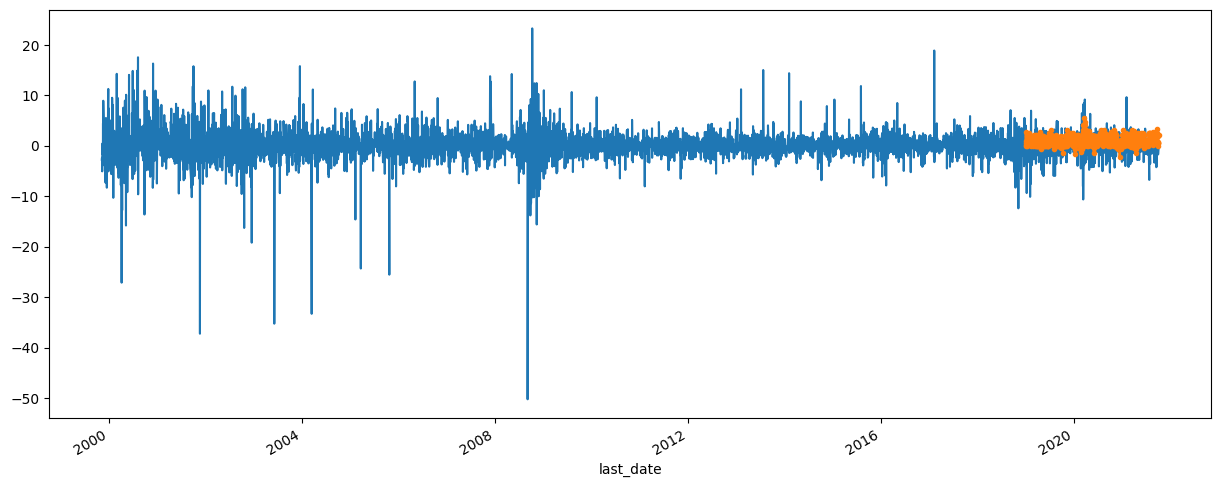

In [41]:
plt.figure(figsize=(15, 6))

y.plot(ax=plt.gca())
y_pred.plot(ax=plt.gca(), legend=None, marker=".")